# Deep Learning Part 2 : Homework 2
## Generative Models - Autoencoders and GANs [60 pts]
**GEC Academy: Winter 2019**  
**Instructor**: Pavlos Protopapas 
**TFs :** Patrick Ohiomoba, Srivatsan Srinivasan

---

### INSTRUCTIONS

- Please include the group number on the assignment
- Please also include the names of all collaborators.
- Make sure all work is contained in the submitted Jupyter Notebook
- Give credit to any  external sources such as blog posts, papers, and source code used in your answers. 
- Plagiarism in any form is not allowed.

---

** Names of all collaborators/group members: ** Yi Ying, Yunfan He, Zhilin Zhang, Shengcheng Yu, Haoyue Du

** Group Number: ** 2

## Report

Students should in addition ot this notebook submit a written report, in which they should detail their explorations of the problems in this Homework in a more formal format.  The final report should be approximately 6 pages, double-spaced, single column. The report format should follow a standard research paper format in terms of organization and include the following sections:

- Introduction including motivations and related Work
- Methods
- Results
- Conclusion


## Tools

### Import all modules

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import zipfile
import pandas
import pandas as pd
import os 
import csv
import numpy as np
import scipy
import progressbar
import keras
from tqdm import tqdm_notebook
from keras.preprocessing import image, sequence
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers import LSTM, SimpleRNN, Input, Flatten, Dense, Activation, Conv2D, MaxPooling2D, Reshape, UpSampling2D, InputLayer
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils, to_categorical
from sklearn.model_selection import train_test_split
# fix random seed for reproducibility
np.random.seed(1)

Using TensorFlow backend.


### Clear all existing models

In [0]:
keras.backend.clear_session()

## Problem 1: Making Faces [55 pts]

We'll be using a subset of the Celeb A dataset to help us build facial generative models.  As described [on the Celeb A site](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

> CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including

> - 10,177 number of identities,
> - 202,599 number of face images, and
> - 5 landmark locations, 40 binary attributes annotations per image.

### Part A: Preparing the Data [5 pts]

**1.A.1.** In the provided data you'll see the `img_align_celeba` directory. The images in that directory will form your dataset.  You may want to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).  

**1.A.2.** Load the attribute data in `list_attr_celeba.txt` into a pandas dataframe.

**1.A.3.** Pick 3 random images from the dataset, plot them, and verify that the attributes are accurate.

### 1.A Answers
***
**1.A.1 Getting dataset `img_align_celeba`**  

Download the `img_align_celeba` dataset and attribute data `list_attr_celeba.txt`.  
All 202599 images are stored in `/celeba/img_align_celeba/`.  
Attribute data is `/list_attr_celeba/list_attr_celeba.txt`

In [0]:
# Create celeba directory and download from AWS
!mkdir celeba && wget https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip

# Download attribute data from personal GitHub repo, to list_attr_celeba/list_attr_celeba.txt
!git clone https://github.com/Yvesyingyi/list_attr_celeba.git

mkdir: cannot create directory ‘celeba’: File exists
fatal: destination path 'list_attr_celeba' already exists and is not an empty directory.


In [0]:
# Extract image files to celeba/img_align_celeba
with zipfile.ZipFile("celeba-dataset.zip","r") as celeba_ref:
  celeba_ref.extractall("celeba/")
with zipfile.ZipFile("celeba/img_align_celeba.zip") as img_align_ref:
  img_align_ref.extractall("celeba")

In [0]:
NUM_IMGS = 202599

**1.A.2 Loading the attribute data**  

Now, the attribute data in `list_attr_celeba.txt` should be loaded in a pandas dataframe. There is 1 line of header in the text file, and values are seperated by one or more whitespaces, so the parameters in function `pd.read_csv` should be set accordingly.

In [0]:
dataFrame = pd.read_csv('list_attr_celeba/list_attr_celeba.txt', header=1, delim_whitespace=True)
dataFrame

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
000007.jpg,1,-1,1,1,-1,-1,1,1,1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
000008.jpg,1,1,-1,1,-1,-1,1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,1
000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


**1.A.3 Plotting and verifying 3 random images**  

3 functions are defined here.  
`get_attributes` is to get all attributes from a certain row in the pandas dataframe, then outputs all the labels that value equals 1.  
`show_image` is to output an image with its labels for a given index.  
`check_rand_img` generates a random index and calls `show_image` on that index.

Everytime `check_rand_img` is called, the notebook will output a random images with all its attributes.

In [0]:
# get all attributes from a certain row
# usage: text = get_attributes(0)
def get_attributes(idx):
  columns = dataFrame.columns.values.tolist()
  attri = ''
  for i in range(len(columns)):
    # if the value is 1, output the attribute
    if dataFrame.iat[idx,i]==1:
      attri += columns[i] + ',\n'
  # remove last comma and newline
  return attri[:-2]


# show the image for the given row, with attributes appended
# usage: show_image(0)
def show_image(idx):
  # get filename
  filename = dataFrame.iloc[idx].name
  img = Image.open('celeba/img_align_celeba/'+ filename)
  # show figure
  fig, (fig1) = plt.subplots(1, 1, figsize=(10, 5))
  fig1.imshow(img)
  fig1.set_title(filename)
  fig1.set_axis_off()
  # set text
  fig1.text(1.02, 0, get_attributes(idx), transform=fig1.transAxes)
  fig.show()
  
# show a random image in 10000 images
def check_rand_img():
  index = random.randint(0, NUM_IMGS - 1)
  show_image(index)
  get_attributes(index)

Calling `check_rand_img` 3 times will generate 3 sample images.

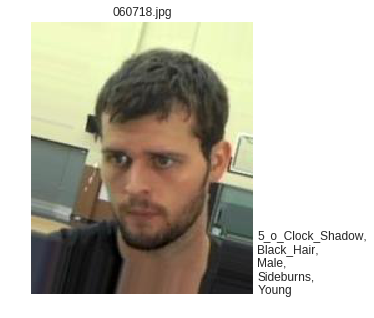

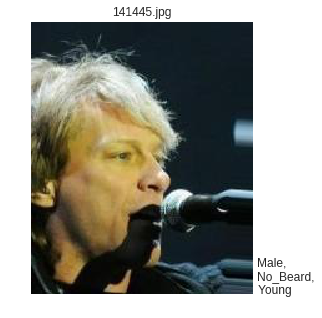

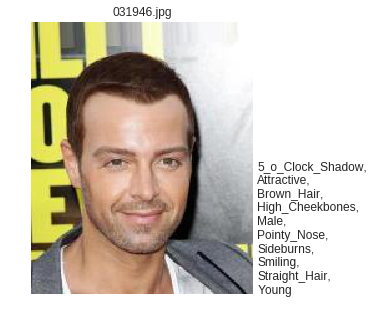

In [0]:
# show 3 random images
for i in range(3):
  check_rand_img()

***

### Part B: Building and Training a Variational Autoencoder Model [25 pts]

**1.B.1.** Create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset.  Print summaries for the encoder, decoder and full autoencoder models.

**1.B.2.** Train your model on the images in the celeba dataset.

**1.B.3.** Choose a random input image.  Encode the image and then Decode the latent representation.  Plot the original image and the reconstructed output.  How do they compare?

**1.B.4.** Choose two celebrity faces from the dataset that differ according to two attributes and taking advantages of alterations of the latent representations image morph from one to the other.  See below for an example.

![](./images/latent_1.png)

**1.B.5.** Generate and visualise around 15 celebrity faces not in your training set.  How do the generated faces compare in quality to celebrity faces from the training samples?

### 1.B Answers
***

In [0]:
# size of training set
INPUT_SIZE = 9000
TRAINING_RATE = 0.9

# 1.A.1 load data
img_list = []
dir_path = 'celeba/img_align_celeba/'
pic_list = os.listdir(dir_path)
for i in range(INPUT_SIZE):
    img_list.append(np.array(Image.open(dir_path + pic_list[i])))
img_array = np.array(img_list)

In [0]:
x_train, x_test = train_test_split(img_array, test_size=0.1)

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
x_train = x_train.reshape((len(x_train), 218, 178, 3, 1))
x_test = x_test.reshape((len(x_test), 218, 178, 3, 1))

In [0]:
def build_conv_encoder(input_shape):

    conv_model = Sequential() # Create sequential model

    # Encoder Layers
    conv_model.add(Conv3D(8, (3, 3, 1), padding='same', activation='relu', input_shape=input_shape))
    conv_model.add(Conv3D(16, (3, 3, 1), strides=(2,2,1), activation='relu'))
    conv_model.add(Conv3D(32, (3, 3, 1), padding='same', activation='relu'))
    conv_model.add(Conv3D(16, (3, 3, 1), strides=(2,2,1), activation='relu'))
    conv_model.add(Conv3D(8, (3, 3, 1), padding='same', activation='relu'))
    conv_model.add(Conv3D(4, (3, 3, 1), strides=(2,2,1), activation='relu', padding='same'))

    # Flatten encoding for bottleneck layer
    conv_model.add(Flatten(name="bottleneck"))

    return conv_model


def build_conv_decoder(bottleneck_size):
    
    conv_model = Sequential() # Create sequential model
    
    # Decoder Layers
    conv_model.add(InputLayer(input_shape=(bottleneck_size,)))
    conv_model.add(Reshape((27, 22, 3, 4)))
    conv_model.add(Conv3D(8, (3, 3, 1), padding='same', activation='relu'))
    conv_model.add(Conv3DTranspose(16, (3, 3, 1), strides=(2,2,1), activation='relu', padding='same'))
    conv_model.add(Conv3D(32, (3, 3, 1), padding='same', activation='relu'))
    conv_model.add(Conv3DTranspose(16, (3, 3, 1), strides=(2,2,1), activation='relu'))
    conv_model.add(Conv3D(8, (3, 3, 1), padding='same', activation='relu'))
    conv_model.add(Conv3DTranspose(1, (3, 3, 1), strides=(2,2,1), activation='sigmoid', padding='same'))
    
    return conv_model

In [0]:
conv_encoder = build_conv_encoder(x_train.shape[1:])
conv_encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 218, 178, 3, 8)    80        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 108, 88, 3, 16)    1168      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 108, 88, 3, 32)    4640      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 53, 43, 3, 16)     4624      
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 53, 43, 3, 8)      1160      
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 27, 22, 3, 4)      292       
_________________________________________________________________
bott

In [0]:
conv_decoder = build_conv_decoder(7128)
conv_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 27, 22, 3, 4)      0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 27, 22, 3, 8)      296       
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 54, 44, 3, 16)     1168      
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 54, 44, 3, 32)     4640      
_________________________________________________________________
conv3d_transpose_2 (Conv3DTr (None, 109, 89, 3, 16)    4624      
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 109, 89, 3, 8)     1160      
_________________________________________________________________
conv3d_transpose_3 (Conv3DTr (None, 218, 178, 3, 1)    73        
Total para

In [0]:
def assemble_autoencoder(input_shape, encoder, decoder):
    
    # assemble the inputs
    inputs = Input(shape=input_shape)
    
    # encode the inputs
    encoding = encoder(inputs)
    
    # reconstruct the input from encoding
    reconstruction = decoder(encoding)

    autoencoder = Model(inputs=inputs, outputs=reconstruction)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [0]:
conv_autoencoder = assemble_autoencoder(x_train.shape[1:], conv_encoder, conv_decoder)

conv_autoencoder.fit(x_train, x_train, epochs=5,
                validation_data=[x_test, x_test])

Instructions for updating:
Use tf.cast instead.
Train on 8100 samples, validate on 900 samples
Epoch 1/5
8100/8100 [==============================] - 102s 13ms/step - loss: 0.5774 - val_loss: 0.5431
Epoch 2/5
8100/8100 [==============================] - 94s 12ms/step - loss: 0.5053 - val_loss: 0.4876
Epoch 3/5
8100/8100 [==============================] - 94s 12ms/step - loss: 0.4855 - val_loss: 0.4854
Epoch 4/5
8100/8100 [==============================] - 94s 12ms/step - loss: 0.4831 - val_loss: 0.4844
Epoch 5/5
8100/8100 [==============================] - 95s 12ms/step - loss: 0.4820 - val_loss: 0.4825


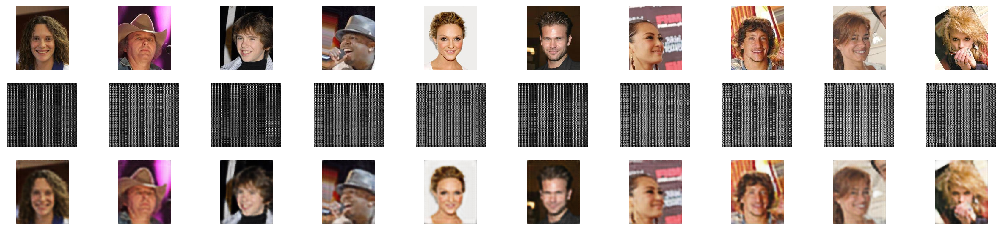

In [0]:
num_images = 10
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

conv_encoded_imgs = conv_encoder.predict(x_test)
conv_decoded_imgs = conv_autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(218,178,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(conv_encoded_imgs[image_idx].reshape(81,88))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(conv_decoded_imgs[image_idx].reshape(218,178,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
# Choose a subset of the test set to visualized for all future examples
indices_test = np.random.choice(list(range(x_test.shape[0])), size=100, replace=False)

In [0]:
# Get a 2-D representation of the latent representations of the test set
tsne = TSNE(n_components=2, init='pca', random_state=0)
x_conv_tsne = tsne.fit_transform(conv_encoded_imgs[indices_test])
x_tsne = tsne.fit_transform(x_test[indices_test].reshape([-1,218*178*3]))

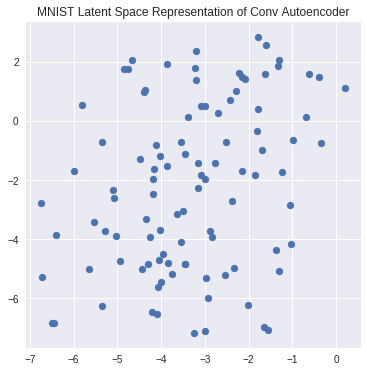

In [0]:
plt.figure(figsize=(6, 6))
plt.scatter(x_conv_tsne[:, 0], x_conv_tsne[:, 1])
plt.title("MNIST Latent Space Representation of Conv Autoencoder")
plt.show()

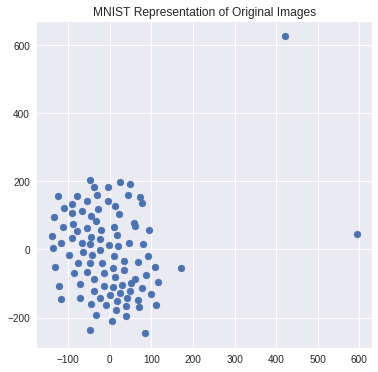

In [0]:
plt.figure(figsize=(6, 6))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1])
plt.title("MNIST Representation of Original Images")
plt.show()

***

### Part C: Building and Training a DCGAN Model [25 pts]

**1.C.1.** Create and compile a DCGAN model for the celebrity faces dataset.  Print summaries for the discriminator and generator models.

**1.C.2.** Train your model on the images in the celeba dataset.

**1.C.3.** Generate and visualise around 15 celebrity faces.  How do the generated faces compare in quality to celebrity faces from the training samples? How do they compare in quality to the faces generated via VAE?


### 1.C
***

In [0]:
img_list = []
dir_path = 'celeba/img_align_celeba/'

pic_list = os.listdir(dir_path)
for i in range(9000):
    img_list.append(np.array(Image.open(dir_path + pic_list[i])))
img_array = np.array(img_list)
print("Dataset size: ", img_array.shape[0])
print("Image dimension: ", img_array.shape[1:])

Dataset size:  9000
Image dimension:  (218, 178, 3)


In [0]:
x_train, x_test = train_test_split(img_array, test_size=0.1)
print("Training set size: ", x_train.shape[0])
print("Testing set size: ", x_test.shape[0])

Training set size:  8100
Testing set size:  900


**Hyperparameters**

In [0]:
original_dim = 218*178*3
intermediate_dim = 256
latent_dim = 2
batch_size = 128
epochs = 15
epsilon_std = 1.0

In [0]:
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

In [0]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [0]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x_pred = decoder(z)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

**There is no significant change after 45 epochs**

In [0]:
hist = vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 8100 samples, validate on 900 samples
Epoch 1/15
8100/8100 [==============================] - 22s 3ms/step - loss: 122467.3070 - val_loss: 72666.3416
Epoch 2/15
8100/8100 [==============================] - 20s 2ms/step - loss: 76107.1052 - val_loss: 94850.0959
Epoch 3/15
8100/8100 [==============================] - 19s 2ms/step - loss: 77004.7616 - val_loss: 72498.6703
Epoch 4/15
8100/8100 [==============================] - 19s 2ms/step - loss: 74780.8666 - val_loss: 72832.5244
Epoch 5/15
8100/8100 [==============================] - 19s 2ms/step - loss: 73816.5872 - val_loss: 71398.1230
Epoch 6/15
8100/8100 [==============================] - 19s 2ms/step - loss: 73511.2684 - val_loss: 73463.5409
Epoch 7/15
8100/8100 [==============================] - 20s 2ms/step - loss: 553969.8966 - val_loss: 70846.1360
Epoch 8/15
8100/8100 [==============================] - 19s 2ms/step - loss: 70915.7688 - val_loss: 70250.3485
Epoch 9/15
8100

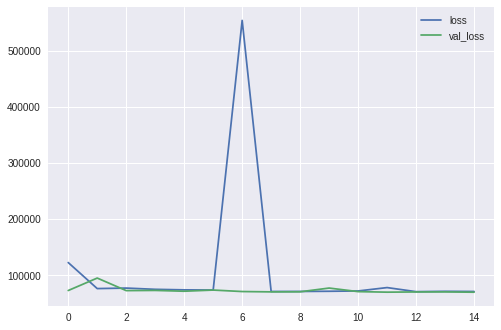

In [0]:
pd.DataFrame(hist.history).plot()

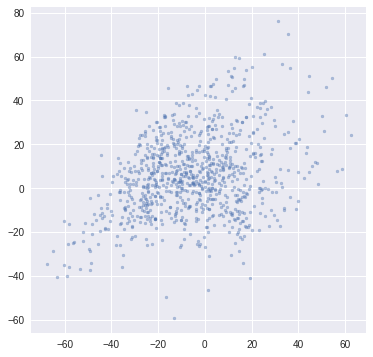

In [0]:
encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1],
            alpha=.4, s=3**2, cmap='viridis')
plt.show()

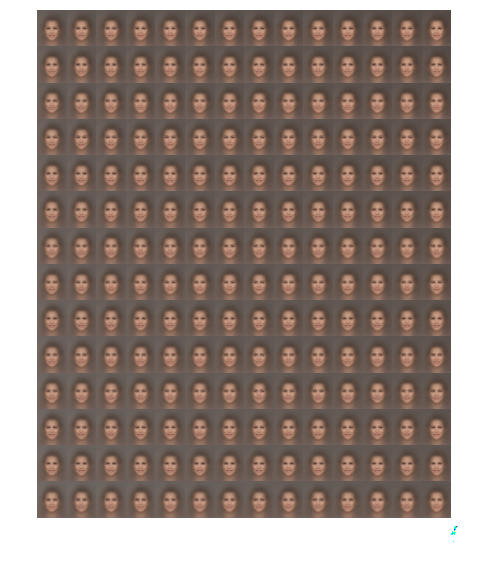

In [0]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28



# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 1, n),
                               np.linspace(0.05, 1, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, 218, 178, 3)
rows = []
for i in range(x_decoded.shape[0]):
    rows.append(np.hstack(list(x_decoded[i])))
show_img = np.vstack(rows)
    

plt.figure(figsize=(10, 10))
plt.imshow(show_img, cmap='gray')
plt.axis('off')
plt.show()

***

## Problem 2: VAEGANIME [45 pts]

Wikipedia describes [Anime]() as follows:

> Anime is hand-drawn and computer animation originating from or associated with Japan.  

> The word anime is the Japanese term for animation, which means all forms of animated media.Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes. The culturally abstract approach to the word's meaning may open up the possibility of anime produced in countries other than Japan For simplicity, many Westerners strictly view anime as a Japanese animation product. Some scholars suggest defining anime as specifically or quintessentially Japanese may be related to a new form of Orientalism

We've provided you a dataset of anime faces and we want you to create a model to generate faces in the same style using a special form of GAN, a VAE-GAN.  The term VAE-GAN was first used by Larsen et. al in their paper [“Autoencoding beyond pixels using a learned similarity metric”](https://arxiv.org/abs/1512.09300).  VAE-GAN models differentiate themselves from GANs in that their generators are variation autoencoders.

![](https://cdn-images-1.medium.com/max/800/0*KEmfTtghsCDu6UTb.png)

### Part A: Preparing the Data [5 pts]

**2.A.1.** We've provided you over 20K anime faces in the form of 64x64 images.  Use them to create your anime face dataset.  You may find it to your advantage to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).

### 2.A Answers: Preparing the data
***

**2.A.1 Preparing png files**  

Download and store all 21551 png images in directory `/anime-faces/data/`  
(`1.png` to `21551.png`)

For Google Colab, download all the images: {

In [0]:
# Create celeba directory and download from AWS
!mkdir anime-faces && wget https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip

mkdir: cannot create directory ‘anime-faces’: File exists


In [0]:
with zipfile.ZipFile("anime-faces.zip","r") as anime_ref:
  anime_ref.extractall("anime-faces/")

}  

If the notebook is in local runtime, just download and store all 21551 png images in directory `/anime-faces/data/`.  
Then, store png images in numpy variables.

In [0]:
img_list = []
dir_path = 'anime-faces/data/'

pic_list = os.listdir(dir_path)
for i in range(21551):
    img_list.append(np.array(Image.open(dir_path + pic_list[i])))
img_array = np.array(img_list)
print("Dataset size: ", img_array.shape[0])
print("Image dimension: ", img_array.shape[1:])

Dataset size:  21551
Image dimension:  (64, 64, 3)


Split training data and testing data, with a ratio of 3 to 1:

Plot 3 random images and check the output:

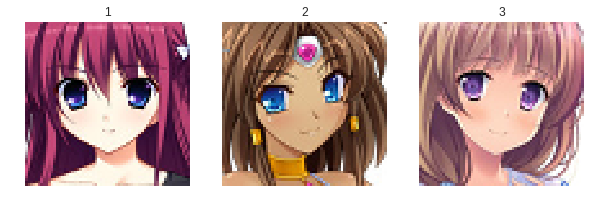

In [0]:
fig, (fig1,fig2,fig3) = plt.subplots(1, 3, figsize=(10, 5))
fig1.imshow(img_array[random.randint(0, 21551 - 1)])
fig1.set_title(1)
fig1.set_axis_off()
fig2.imshow(img_array[random.randint(0, 21551 - 1)])
fig2.set_title(2)
fig2.set_axis_off()
fig3.imshow(img_array[random.randint(0, 21551 - 1)])
fig3.set_title(3)
fig3.set_axis_off()
fig.show()

***

### Part B: Building and Training a DCGAN [20 pts]

**2.B.1.** Create and compile a DCGAN model for the anime faces dataset.  Print summaries for the generator and discriminator models

**2.B.2.** Train your model on the images in the anime faces dataset.

**2.B.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples?

### 2.B Answers
***

In [0]:
# Load data and preprocess
img_list = []
dir_path = 'anime-faces/data/'

pic_list = os.listdir(dir_path)
for i in range(21551):
    img_list.append(np.array(Image.open(dir_path + pic_list[i])))
img_array = np.array(img_list)
print("Dataset size: ", img_array.shape[0])
print("Image dimension: ", img_array.shape[1:])

x_train, x_test = train_test_split(img_array, test_size=0.1)
print("Training set size: ", x_train.shape[0])
print("Testing set size: ", x_test.shape[0])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), 64, 64, 3, 1))
x_test = x_test.reshape((len(x_test), 64, 64, 3, 1))

Dataset size:  21551
Image dimension:  (64, 64, 3)
Training set size:  19395
Testing set size:  2156


In [0]:
# noise vector
z_dim = 300

In [0]:
def leakyReLU(x,neg_scale=0.01):
  if x > 0:
    return x
  else:
    return neg_scale*x

In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)


#GENERATOR
g = Sequential()

g.add(Dense(8*8*3*4, activation='relu'))
g.add(BatchNormalization(momentum=0.9))
g.add(Reshape((8, 8, 3, 4)))
g.add(Conv3D(8, (3, 3, 1), padding='same', activation='relu'))
g.add(BatchNormalization(momentum=0.9))
g.add(Conv3DTranspose(16, (3, 3, 1), strides=(2,2,1), activation='relu', padding='same'))
g.add(BatchNormalization(momentum=0.9))
g.add(Conv3D(32, (3, 3, 1), padding='same', activation='relu'))
g.add(BatchNormalization(momentum=0.9))
g.add(Conv3DTranspose(16, (3, 3, 1), strides=(2,2,1), activation='relu', padding='same'))
g.add(BatchNormalization(momentum=0.9))
g.add(Conv3D(8, (3, 3, 1), padding='same', activation='relu'))
g.add(BatchNormalization(momentum=0.9))
g.add(Conv3DTranspose(1, (3, 3, 1), strides=(2,2,1), activation='sigmoid', padding='same'))


g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#DISCRIMINATOR
d = Sequential()
d.add(Conv3D(8, (3, 3, 1), padding='same', activation=LeakyReLU(alpha=0.2), input_shape=(64,64,3,1)))
d.add(Conv3D(16, (3, 3, 1), strides=(2,2,1), activation=LeakyReLU(alpha=0.2)))
d.add(BatchNormalization(momentum=0.9))
d.add(Conv3D(32, (3, 3, 1), padding='same', activation=LeakyReLU(alpha=0.2)))
d.add(BatchNormalization(momentum=0.9))
d.add(Conv3D(16, (3, 3, 1), strides=(2,2,1), activation=LeakyReLU(alpha=0.2)))
d.add(BatchNormalization(momentum=0.9))
d.add(Conv3D(8, (3, 3, 1), padding='same', activation=LeakyReLU(alpha=0.2)))
d.add(BatchNormalization(momentum=0.9))
d.add(Conv3D(1, (3, 3, 1), strides=(2,2,1), activation=LeakyReLU(alpha=0.2), padding='same'))
d.add(BatchNormalization(momentum=0.9))
d.add(Flatten())
d.add(Dense(1, activation=LeakyReLU(alpha=0.2)))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#GAN
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
g.summary()
d.summary()
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 768)               231168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 768)               3072      
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 3, 4)        0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 8, 3, 8)        296       
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 3, 8)        32        
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 16, 16, 3, 16)     1168      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 3, 16)     64        
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 64, 64, 3)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(x_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm_notebook(range(batchCount)):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 50
Batch size: 128
Batches per epoch: 126


--------------- Epoch 1 ---------------


Instructions for updating:
Use tf.cast instead.


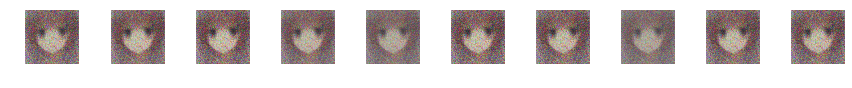

--------------- Epoch 10 ---------------


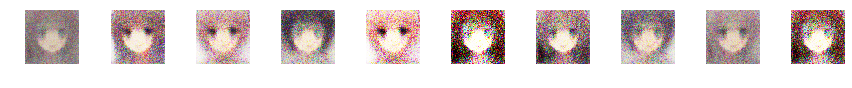

--------------- Epoch 20 ---------------


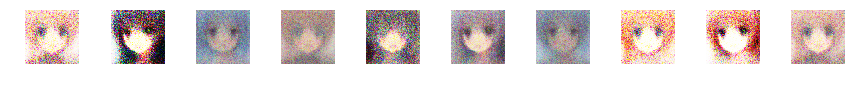

--------------- Epoch 30 ---------------


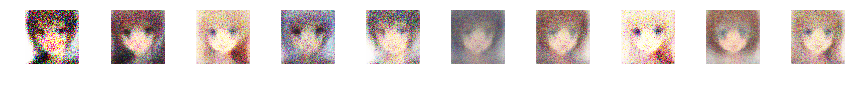

--------------- Epoch 40 ---------------


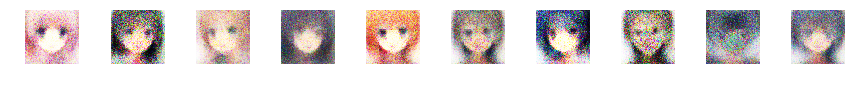

--------------- Epoch 50 ---------------


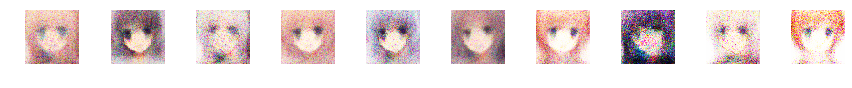

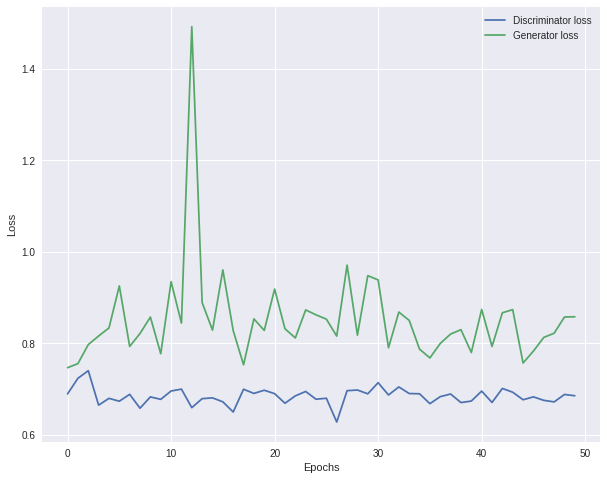

In [0]:
train(epochs=50, plt_frq=10, BATCH_SIZE=128)

***

### Part C: Building and Training a VAE-GAN [20 pts]

**2.C.1.** Create and compile a VAE-GAN model for the anime faces dataset.  Print summaries for the encoder, decoder and discriminator models

**2.C.2.** Train your model on the images in the anime faces dataset.

**2.C.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples? How do they compare to the faces from the traditional GAN.

### 2.C Answers
***

In [0]:
x_train, x_test = train_test_split(img_array, test_size=0.1)
print("Training set size: ", x_train.shape[0])
print("Testing set size: ", x_test.shape[0])

Training set size:  19395
Testing set size:  2156


In [0]:
original_dim = 12288
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 15
epsilon_std = 1.0

In [0]:
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

In [0]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [0]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x_pred = decoder(z)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

In [0]:
hist = vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 19395 samples, validate on 2156 samples
Epoch 1/15
19395/19395 [==============================] - 9s 469us/step - loss: 15499619258.4287 - val_loss: 7379.9404
Epoch 2/15
19395/19395 [==============================] - 6s 323us/step - loss: 7361.8544 - val_loss: 7229.4859
Epoch 3/15
19395/19395 [==============================] - 6s 324us/step - loss: 7674.8393 - val_loss: 7649.4817
Epoch 4/15
19395/19395 [==============================] - 6s 324us/step - loss: 7642.2101 - val_loss: 7581.2709
Epoch 5/15
19395/19395 [==============================] - 6s 328us/step - loss: 7523.3310 - val_loss: 7400.1103
Epoch 6/15
19395/19395 [==============================] - 6s 327us/step - loss: 7412.6620 - val_loss: 7243.6539
Epoch 7/15
19395/19395 [==============================] - 6s 327us/step - loss: 7337.5135 - val_loss: 7288.9277
Epoch 8/15
19395/19395 [==============================] - 6s 326us/step - loss: 7275.5550 - val_loss: 7158.4564


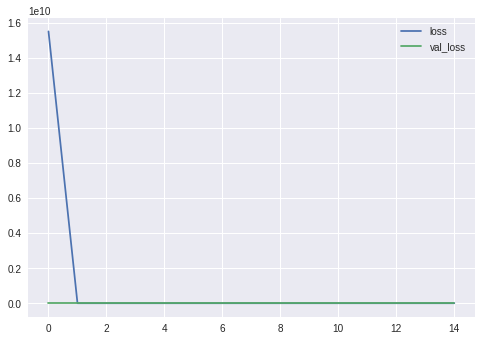

In [0]:
pd.DataFrame(hist.history).plot()

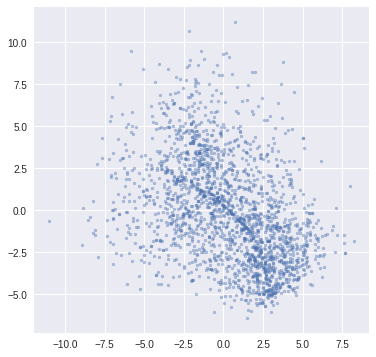

In [0]:
encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1],
            alpha=.4, s=3**2, cmap='viridis')
plt.show()

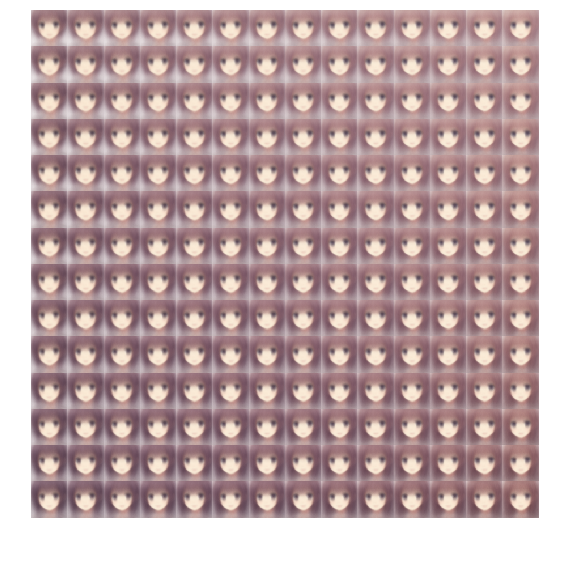

In [0]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28



# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 1, n),
                               np.linspace(0.05, 1, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, 64, 64, 3)
rows = []
for i in range(x_decoded.shape[0]):
    rows.append(np.hstack(list(x_decoded[i])))
show_img = np.vstack(rows)
    

plt.figure(figsize=(10, 10))
plt.imshow(show_img, cmap='gray')
plt.axis('off')
plt.show()

***

### References

[1] GEC Labs

[2] [A Tutorial on Variational Autoencoders with a Concise Keras Implementation | Louis Tiao](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/)

[3] [Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with
deep convolutional generative adversarial networks. arXiv preprint
arXiv:1511.06434.](https://arxiv.org/abs/1511.06434)

[4] [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)

[5] [VAE, GAN, VAEGAN – Praveen's Blog](https://pravn.wordpress.com/category/vae-gan-vaegan)

[6] [Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with
deep convolutional generative adversarial networks. arXiv preprint
arXiv:1511.06434.](https://arxiv.org/abs/1512.09300)